In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import numpy as np
from matplotlib.dates import DateFormatter
from pathlib import Path

import multiprocessing as mp
mp.set_start_method("fork")
from concurrent.futures import ProcessPoolExecutor, as_completed
import seaborn as sns
sns.set_context("talk")

In [2]:
def load_file(f):
    print(f)
    df = pd.read_csv(f"{f}", parse_dates=[0], index_col=[0], low_memory=False)
    if isinstance(f, str):
        node_name = f.split('_')[1]
        jobid = f.split('_')[2].split('.')[0]
    else:
        node_name = f.name.split('_')[1]
        jobid = f.name.split('_')[2]
    df["node"] = node_name
    df["jobid"] = jobid
    
    return df


### Load in data

In [3]:
%%time

files = [
    "data/condor_nid00457_62736979.csv"
#     "data/condor_nid00291_62267193.csv",
#     "data/condor_nid00302_61065866.csv",
#     "data/condor_nid00301_61065896.csv",
#     "data/condor_nid00337_61065868.csv",
#     "data/condor_nid00307_61065892.csv",
#     "data/condor_nid00368_61065897.csv",
#     "data/condor_nid00318_61065898.csv",
#     "data/condor_nid00406_61065859.csv",
#     "data/condor_nid00362_61065864.csv",
#     "data/condor_nid00333_61065893.csv",
#     "data/condor_nid00441_61065858.csv",
#     "data/condor_nid00299_61065894.csv",
#     "data/condor_nid00500_61065865.csv",
#     "data/condor_nid00300_61065867.csv",
#     "data/condor_nid00341_61065863.csv",
]

# files = Path('data').glob("*626373*.csv")

executor = ProcessPoolExecutor(max_workers=4)

futures = [executor.submit(load_file, f) for f in files]
_all = [f.result() for f in as_completed(futures)]

total_data = pd.concat(_all)

total_data['mem_rss_GB'] = total_data['mem_rss'] / (1024**3)
total_data['mem_vms_GB'] = total_data['mem_vms'] / (1024**3)
total_data['name'] = total_data.name.astype(str)
total_data = total_data[~total_data.name.str.contains('condor')]
total_data = total_data[~total_data.name.str.contains('bash')]
total_data = total_data[~total_data.name.str.contains('srun')]
total_data = total_data[~total_data.name.str.contains('tee')]
total_data = total_data[~total_data.name.str.contains('shifter')]
total_data = total_data[~total_data.name.str.contains('sleep')]

total_data.sort_index(inplace=True)

data/condor_nid00457_62736979.csv
CPU times: user 1 s, sys: 441 ms, total: 1.44 s
Wall time: 46.3 s


In [4]:
total_data.head(2)

,pid,name,num_threads,cpu_num,cpu_user,cpu_system,cpu_iowait,cpu_children_system,cpu_children_user,idle,...,read_count,write_count,read_chars,write_chars,cmdline,current_dir,node,jobid,mem_rss_GB,mem_vms_GB
@timestamp,,,,,,,,,,,,,,,,,,,,,
2022-09-12 10:32:08.774723,13241,java,18,10,0.92,0.23,0.01,0.0,0.0,NaN,...,821.0,20.0,3177786.0,56.0,/usr/bin/java|-classpath|/global/cfs/cdirs/jaw...,/global/cscratch1/sd/jaws_jtm/jaws-condor/work...,nid00457,62736979,0.041737,33.244904
2022-09-12 10:32:09.477949,13241,java,17,10,1.64,0.23,0.01,0.0,0.0,NaN,...,830.0,20.0,3178356.0,56.0,/usr/bin/java|-classpath|/global/cfs/cdirs/jaw...,/global/cscratch1/sd/jaws_jtm/jaws-condor/work...,nid00457,62736979,0.042091,33.244904


### Sorts unique process names by the number of time points

In [5]:
name, counts = np.unique(total_data.name, return_counts=True)
_sort = np.argsort(counts)[::-1]

name = name[_sort]
counts = counts[_sort]

for n, c in zip(name, counts):
    print(n, c)

python3 94040
seqkit 36861
sh 22715
nanocompore 19444
f5c 8044
slow5tools 6277
xpore 6129
sync 4245
samtools 3807
python 2271
perl 1953
gzip 1316
easypredict.sh 1069
predictexons.sh 1066
metaeuk 1065
blastp.sh 1058
minimap2 844
hisat2-align-s 651
java 298
awk 172
bamCoverage 148
bgzip 46
hisat2-build-s 40
pigz 25
reformat.sh 24
featureCounts 20
tar 16
cut 15
shuf 2
sed 1
mv 1
head 1
stats.sh 1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


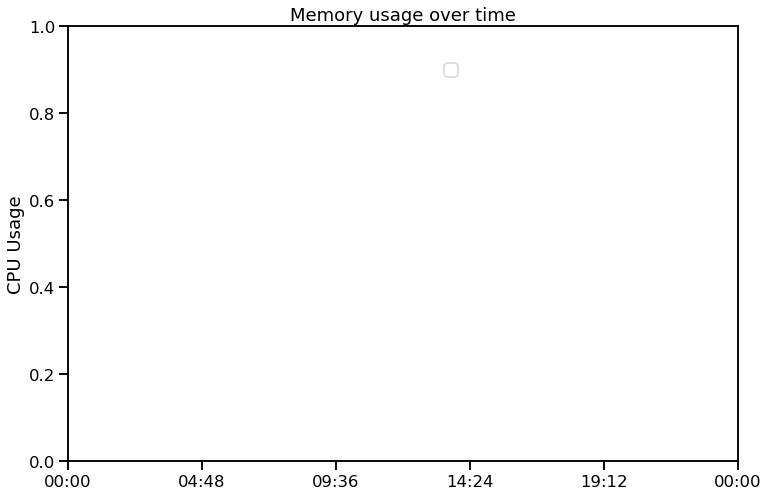

In [6]:
total_data.sort_index(inplace=True)

# remove duplicate legends
# https://stackoverflow.com/a/56253636
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    leg = ax.legend(*zip(*unique), loc='center left', bbox_to_anchor=(0.55, 0.9), ncol=3, fancybox=True)
    # Set legend to alpha=1.0
    # https://stackoverflow.com/a/42403471
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

fig, ax = plt.subplots(figsize=(12,8))

nodes = total_data.node.unique()
cmap = cm.get_cmap('tab20b')
x = list(cmap.colors)

bad_prog = ["sh", "curl_plugin", "mv", "data_plugin"]

colors = {}
# Give each process a unique color
for n, color in zip(name, x):
    if n in bad_prog:
        continue
    if n in colors.keys():
        continue
    else:
        colors[n] = color
        
memory = []

# Plot the memory usage over time including all processes
for n, c in zip(name, counts):
    if n != 'spades-core':
        continue
    data = total_data[total_data['name'] == n]
    # data = data[(data.index > "2022-07-13 13:00:00.000000") & (data.index < "2022-07-13 14:00:00.000000")]
    pids = data.pid.unique()

    for pid in pids:
        process_data = data[data.pid == pid]
        nid = process_data.iloc[0].node
        mem = process_data.mem_vms_GB.rolling("20s").max()
        memory.append(mem.to_numpy())
        try:

            mem.plot(c=colors[n], alpha=0.5, label=n)
        except KeyError as e:
            print(e)
            cpu.plot(c='black', alpha=0.8)

# plt.ylim(0,120)
legend_without_duplicate_labels(ax)

date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)
plt.ylim(0, None)
plt.title(f'Memory usage over time')
plt.ylabel("CPU Usage")
plt.show()




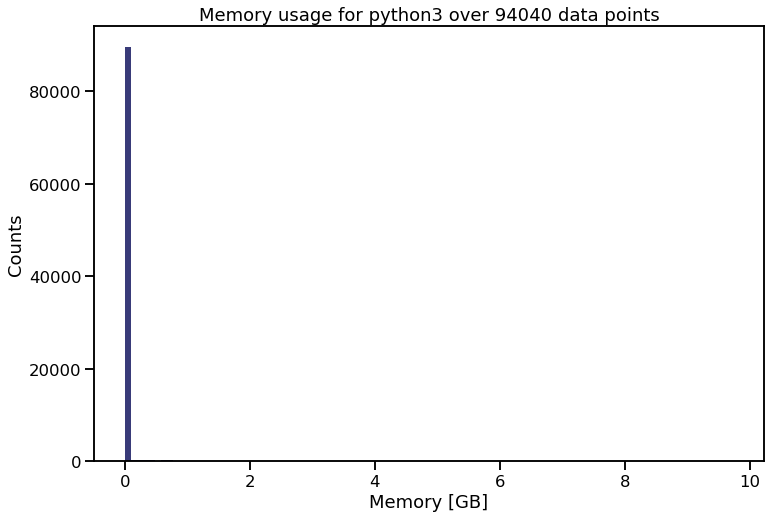

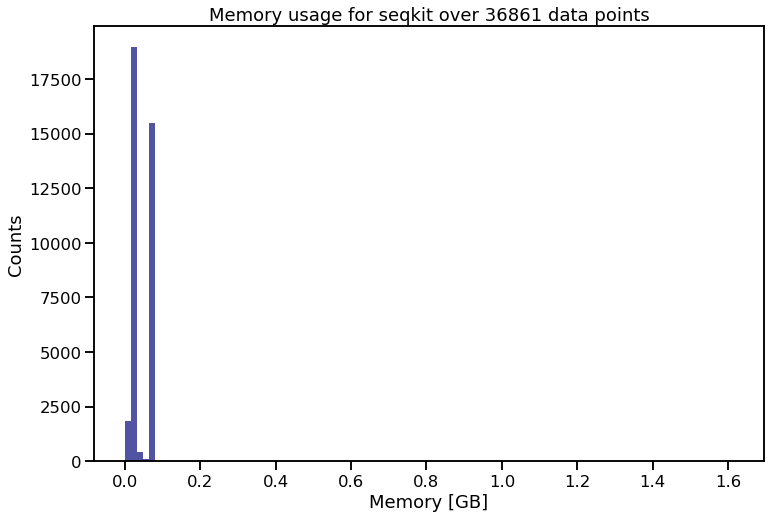

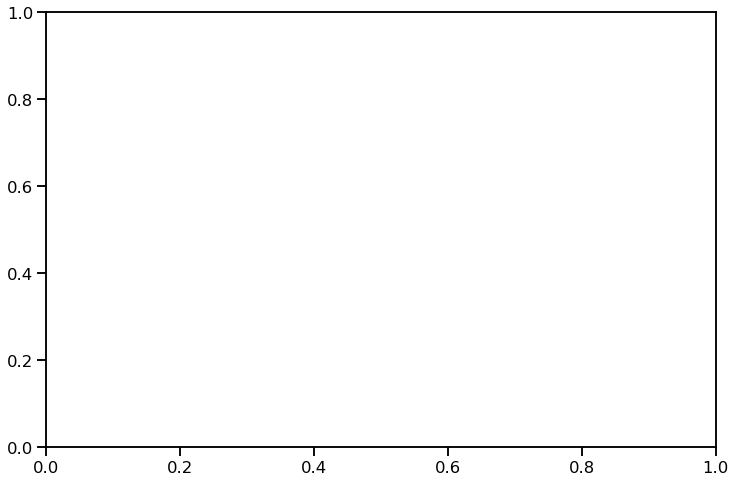

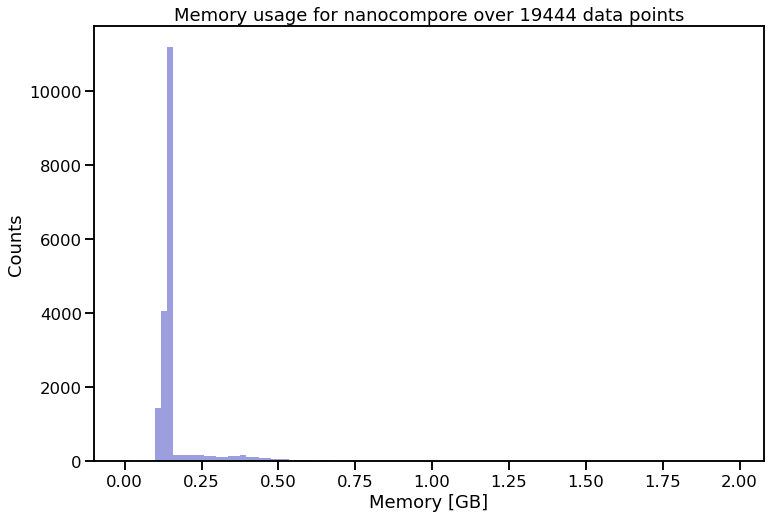

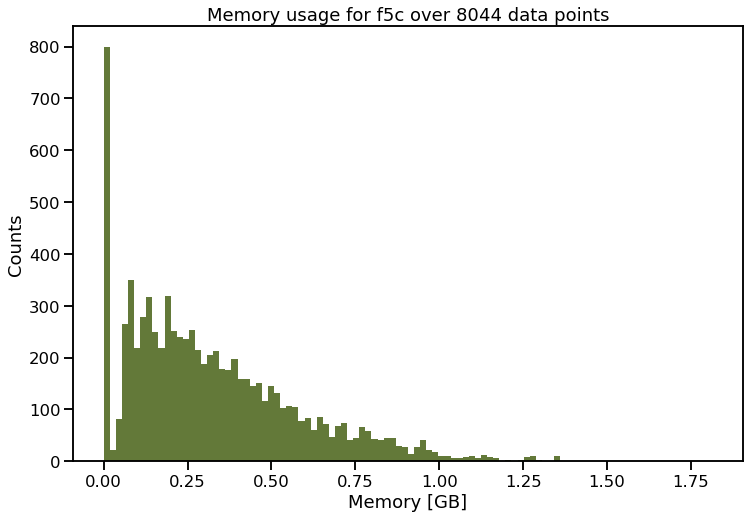

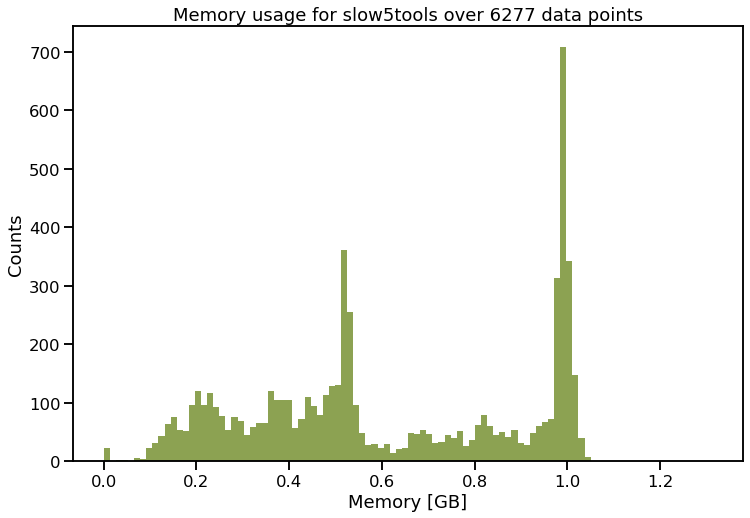

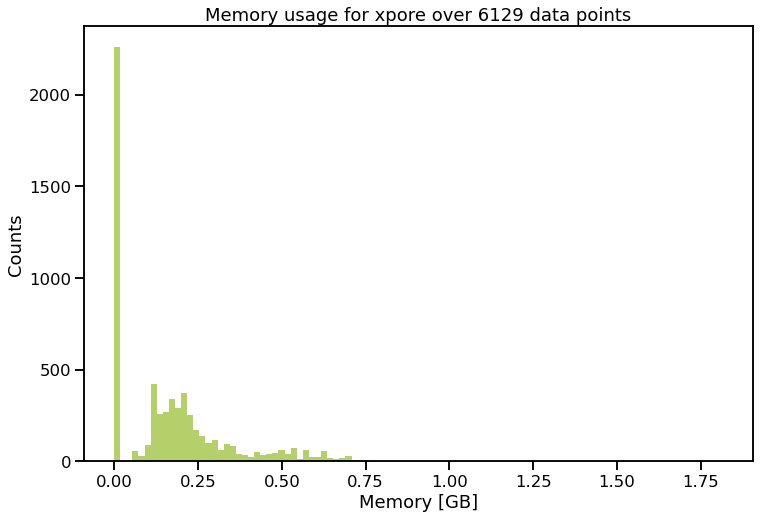

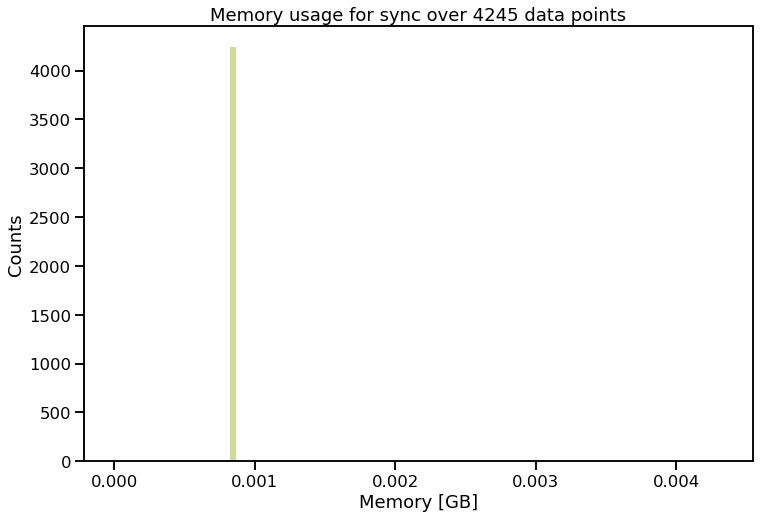

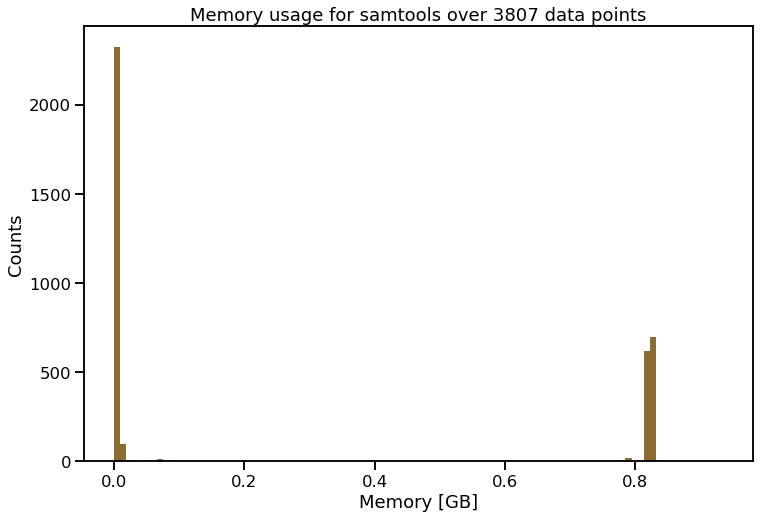

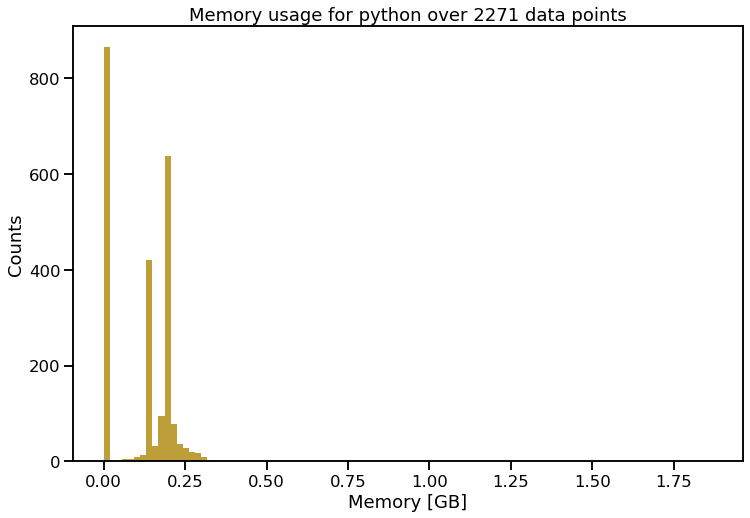

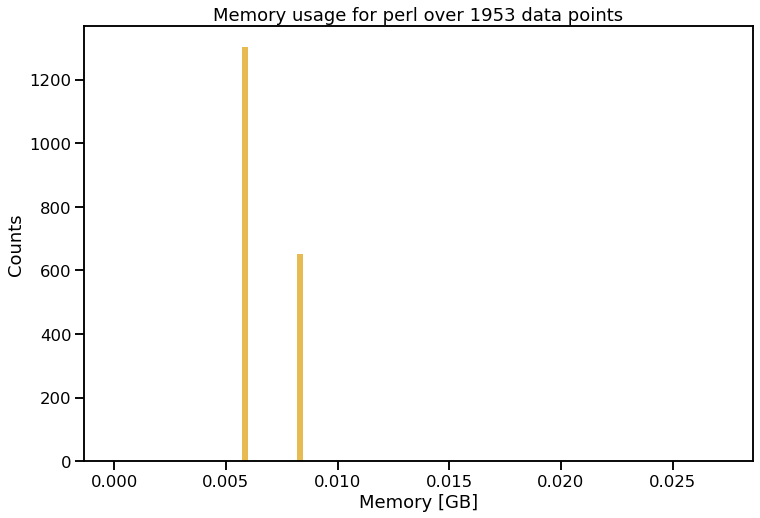

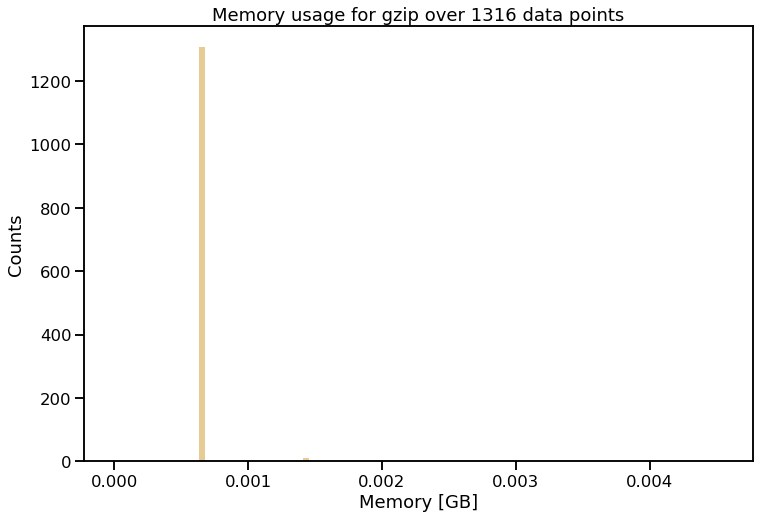

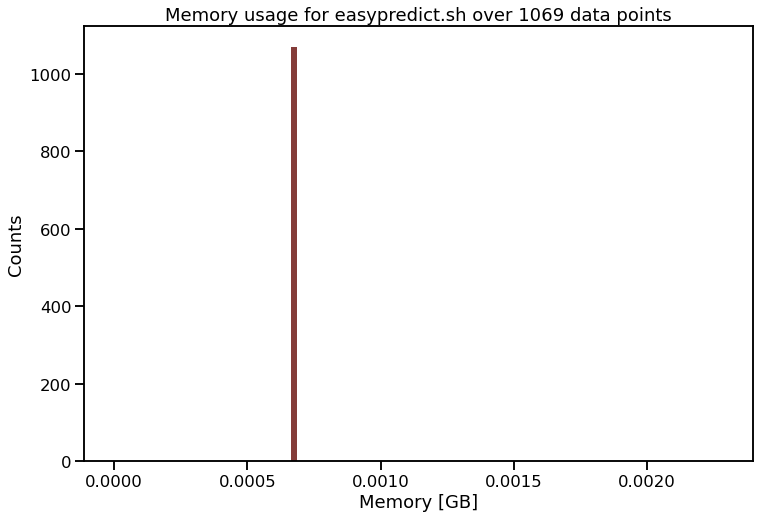

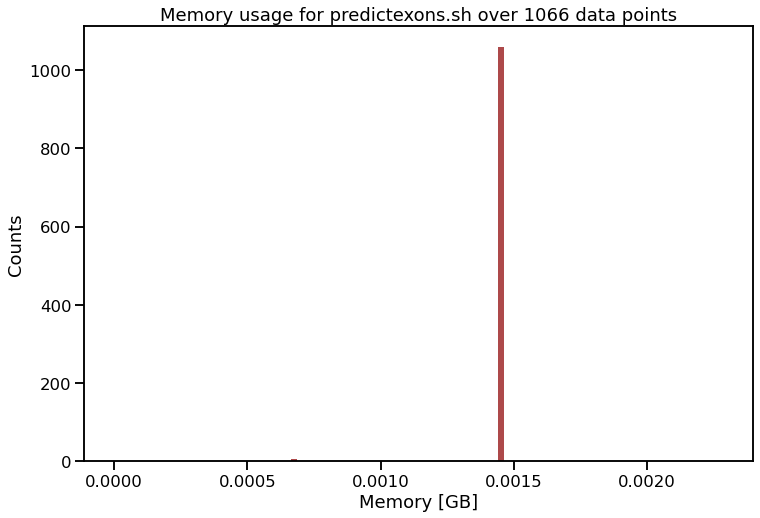

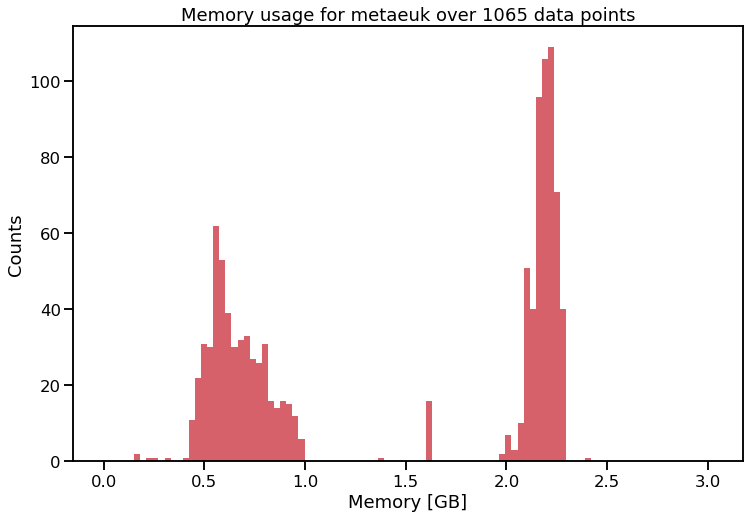

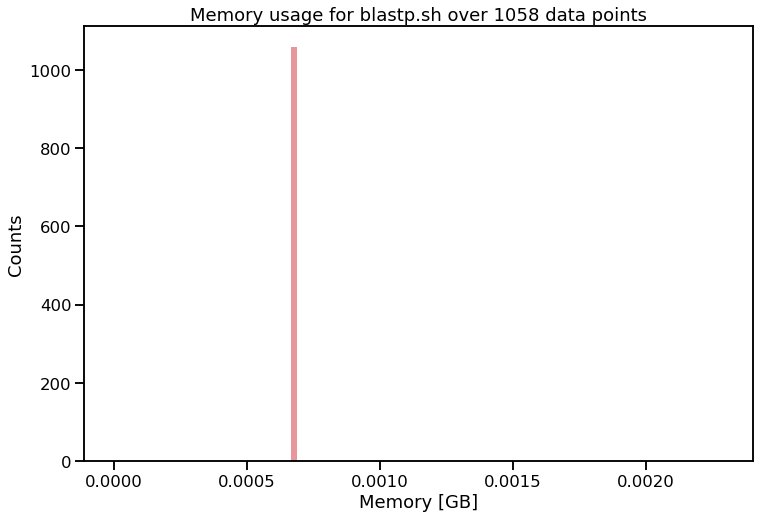

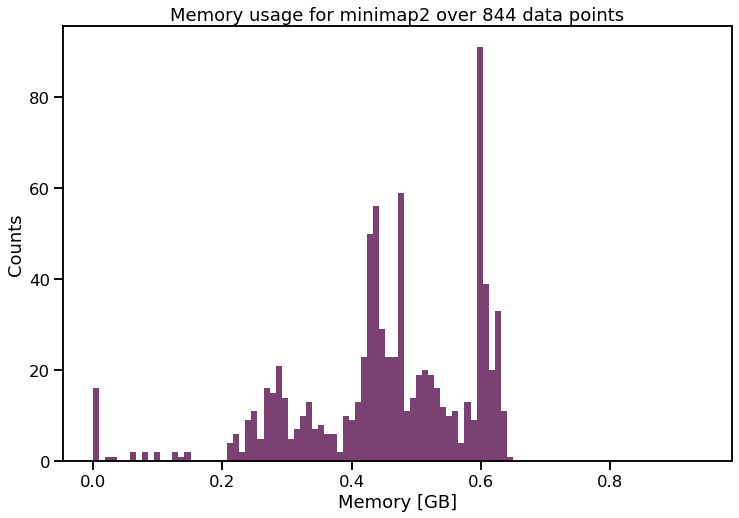

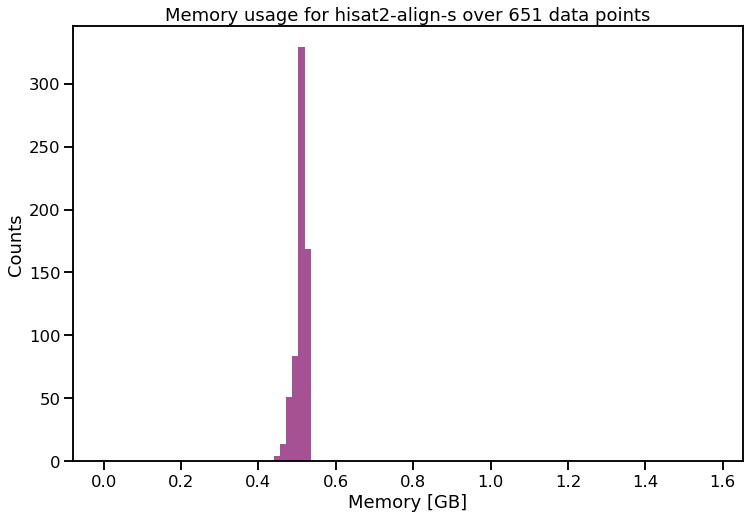

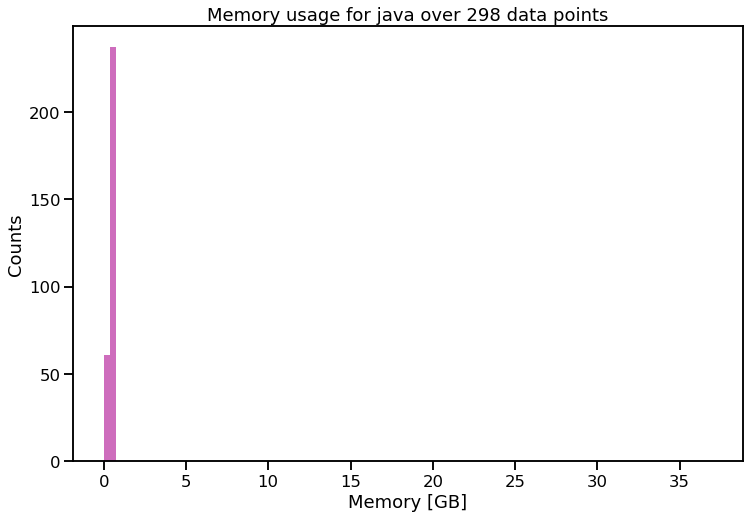

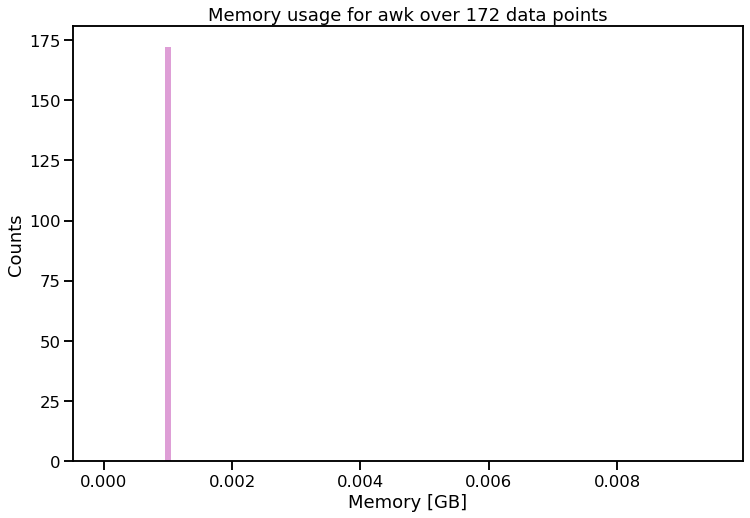

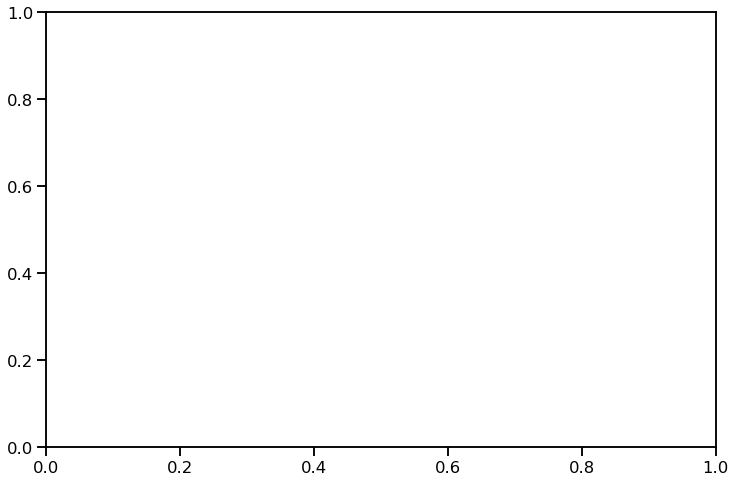

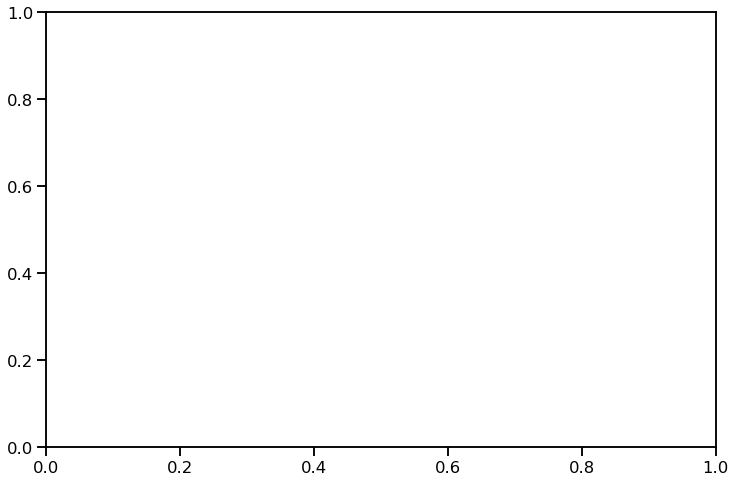

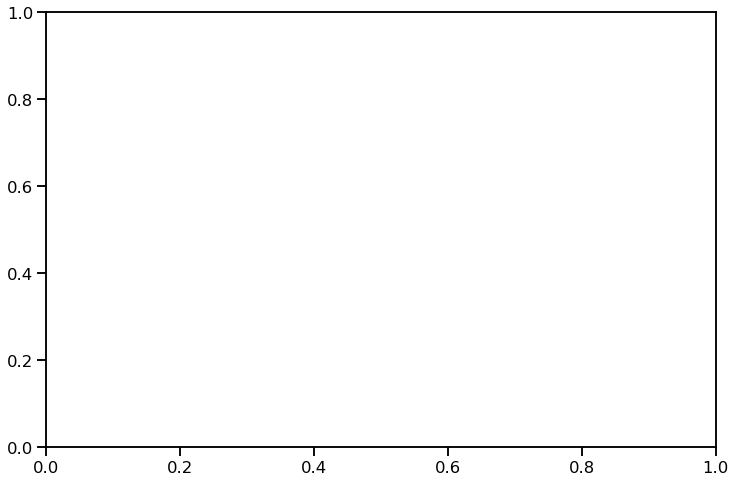

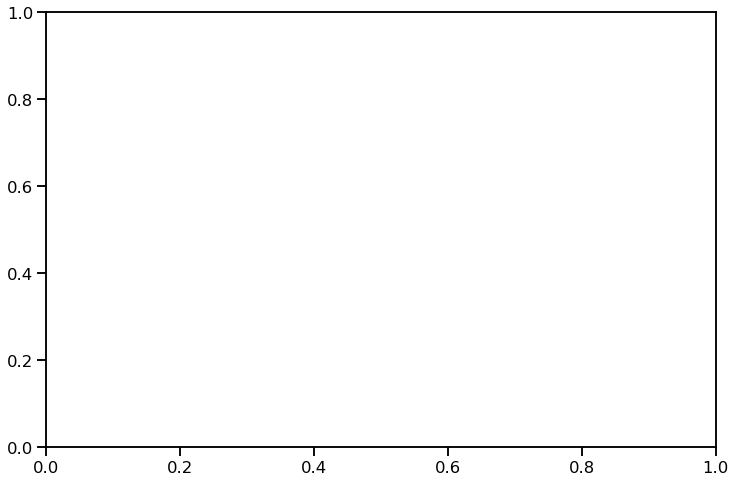

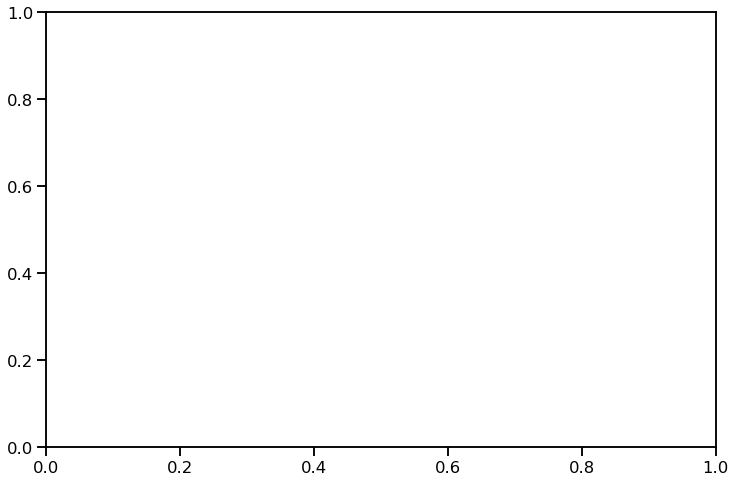

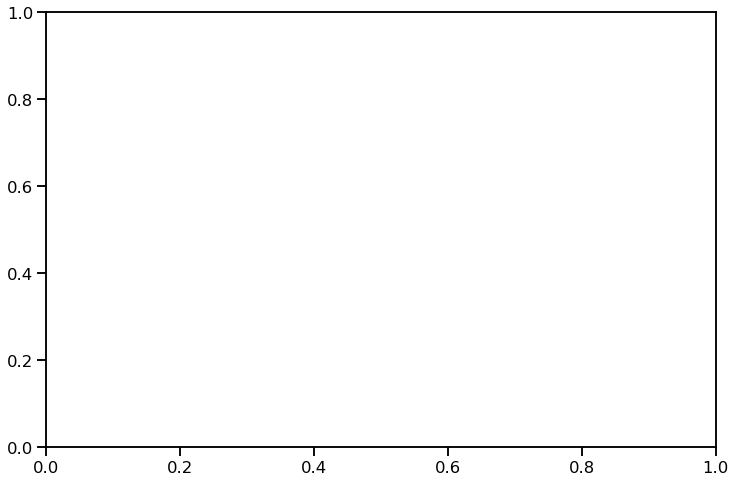

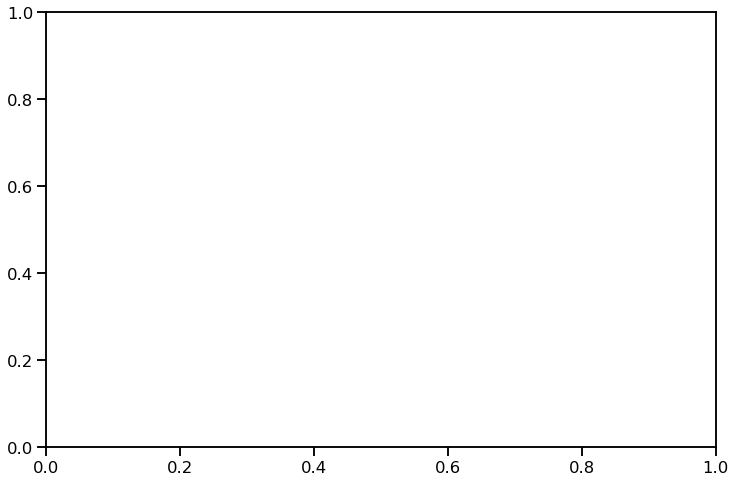

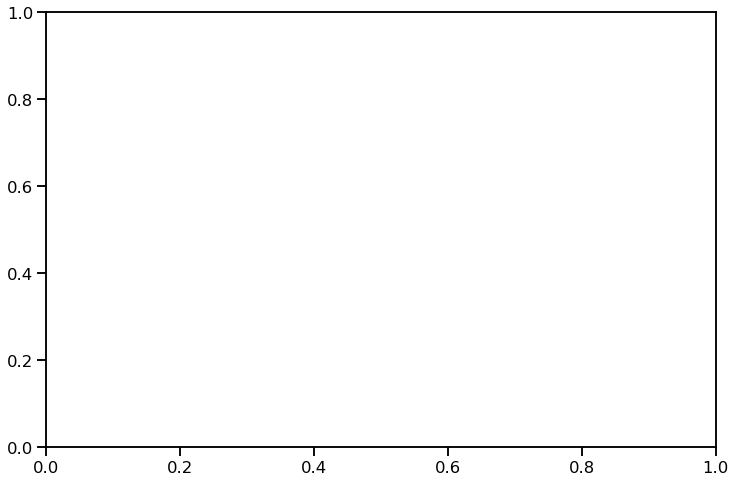

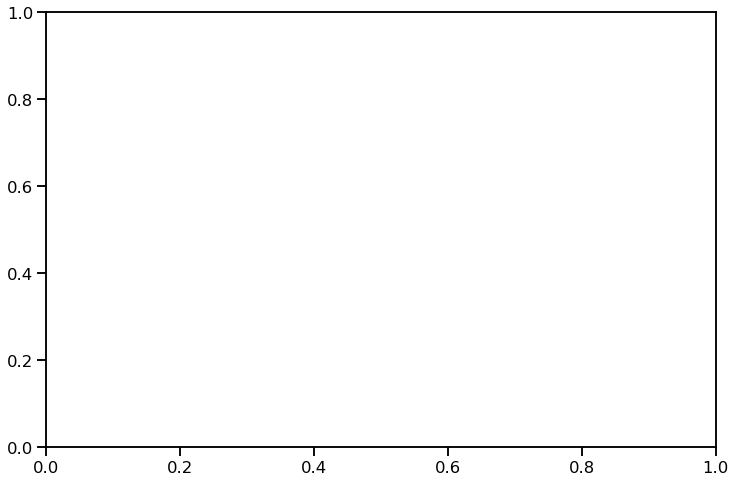

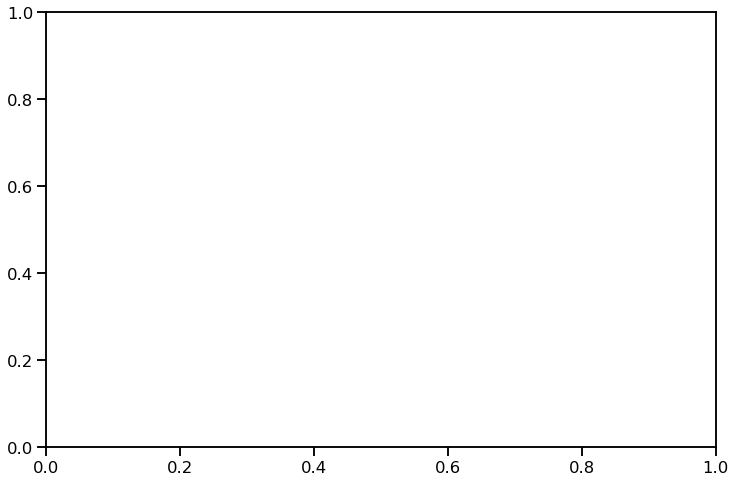

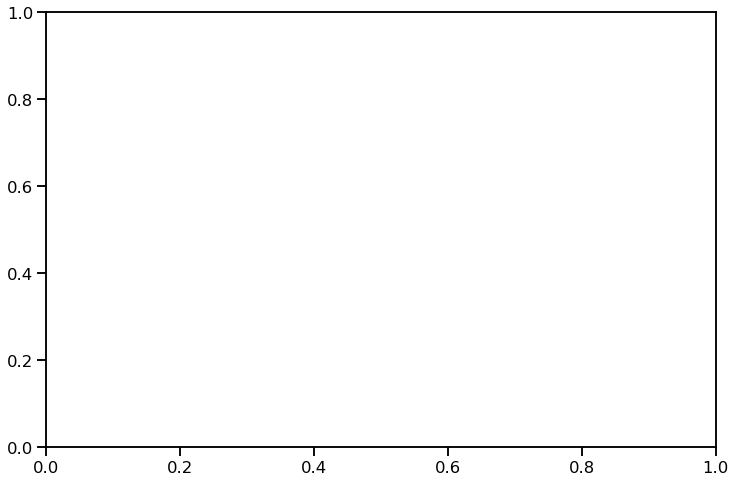

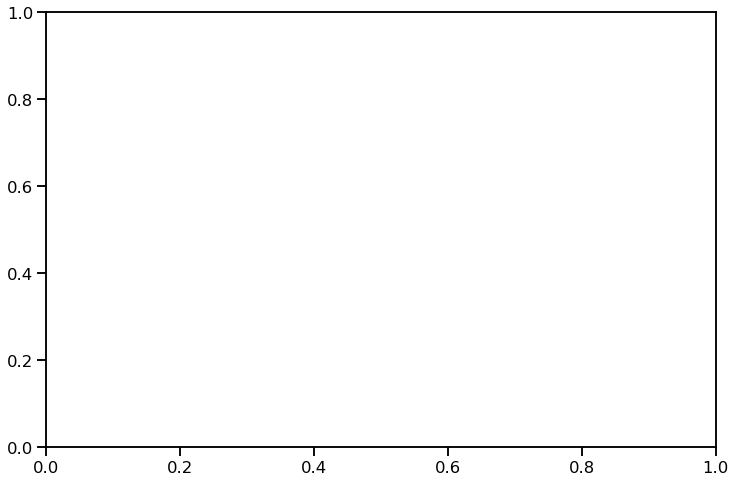

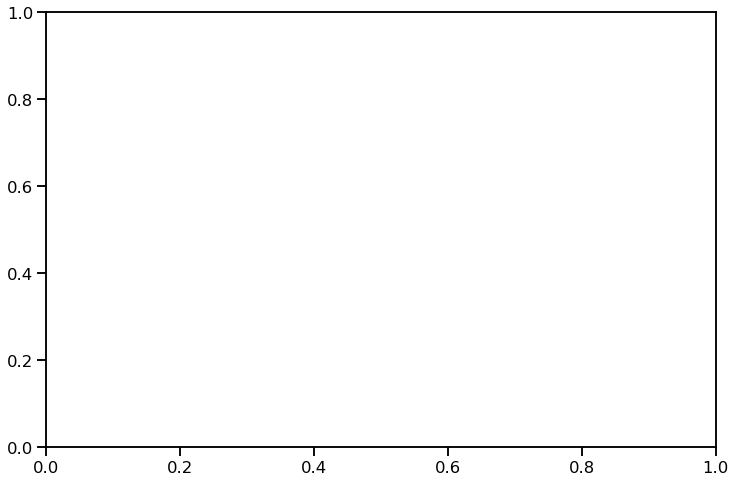

In [7]:
for n, c in zip(name, counts):
    fig, ax = plt.subplots(figsize=(12,8))
    out = total_data[total_data.name == n].mem_rss_GB
    out2 = total_data[total_data.name == n].mem_vms_GB
    
    try:
        plt.hist(out, range=[0,np.max(out2)], bins=100, color=colors[n])
        # plt.hist(out2, alpha=0.5, range=[0,np.max(out2)], bins=100, color=colors[n])
    except:
        continue
    plt.title(f"Memory usage for {n} over {len(out)} data points")
    plt.ylabel("Counts")
    plt.xlabel("Memory [GB]")
    plt.show()

### Aggregate processes by name and give a table

In [8]:
total_data.groupby('name').agg(
    {
        'mem_rss_GB': ['max', 'mean'],
        'mem_vms_GB': ['max', 'mean'],
        'num_threads' : ['max', 'mean'],
    }
)

mem_rss_GB           mem_vms_GB            num_threads  \
                       max      mean        max       mean         max   
name                                                                     
awk               0.000973  0.000972   0.009483   0.009483           1   
bamCoverage       0.042725  0.033397   0.414413   0.223608           4   
bgzip             0.016068  0.016032   1.224277   1.224277          18   
blastp.sh         0.000671  0.000671   0.002289   0.002289           1   
cut               0.000858  0.000853   0.004345   0.004345           1   
easypredict.sh    0.000668  0.000668   0.002285   0.002285           1   
f5c               1.355930  0.322989   1.813633   0.683655          11   
featureCounts     0.267010  0.242260   1.399719   1.357324          17   
gzip              0.001427  0.000654   0.004547   0.004545           1   
head              0.000858  0.000858   0.004345   0.004345           1   
hisat2-align-s    0.532990  0.509368   1.573395   1.563792          17   
hisat2-build-s    0.089851  0.064629   0.151730   0.104165           1   
java              0.724361  0.521886  36.981853  35.172170          69   
metaeuk           2.390694  1.444183   3.022274   2.833588           2   
minimap2          0.649387  0.454900   0.942242   0.689222           6   
mv                0.001637  0.001637   0.016693   0.016693           1   
nanocompore       0.861607  0.173453   1.979744   1.263139          13   
perl              0.008202  0.006594   0.027245   0.027245           1   
pigz              0.047295  0.004865   4.620743   0.403607          66   
predictexons.sh   0.001461  0.001456   0.002285   0.002285           1   
python            0.416138  0.112308   1.868534   0.765677          11   
python3           6.518059  0.129042   9.733734   0.729219          71   
reformat.sh       0.002525  0.002525   0.011288   0.011288           1   
samtools          0.831078  0.293378   0.934441   0.355206           4   
sed               0.001083  0.001083   0.012939   0.012939           1   
seqkit            0.895725  0.040781   1.613529   0.757313          18   
sh                0.002399  0.000040   0.011162   0.000214           1   
shuf              0.001762  0.001316   0.004799   0.004578           1   
slow5tools        1.044750  0.614206   1.312988   0.755108           5   
stats.sh          0.003284  0.003284   0.008190   0.008190           1   
sync              0.000847  0.000847   0.004333   0.004333           1   
tar               0.002964  0.002443   0.020790   0.018548           1   
xpore             0.881397  0.163297   1.815681   0.727912           4   

                            
                      mean  
name                        
awk               1.000000  
bamCoverage       1.162162  
bgzip            18.000000  
blastp.sh         1.000000  
cut               1.000000  
easypredict.sh    1.000000  
f5c               5.998508  
featureCounts    16.150000  
gzip              1.000000  
head              1.000000  
hisat2-align-s   17.000000  
hisat2-build-s    1.000000  
java             62.731544  
metaeuk           1.998122  
minimap2          2.773697  
mv                1.000000  
nanocompore       4.362477  
perl              1.000000  
pigz              8.960000  
predictexons.sh   1.000000  
python            3.279613  
python3           4.768907  
reformat.sh       1.000000  
samtools          1.850801  
sed               1.000000  
seqkit           12.457421  
sh                1.000000  
shuf              1.000000  
slow5tools        2.286921  
stats.sh          1.000000  
sync              1.000000  
tar               1.000000  
xpore             1.203622

### Plot the memory usage of the workflow over time

python3
seqkit
nanocompore
f5c
slow5tools
xpore
sync
samtools
python
gzip
easypredict.sh
predictexons.sh
metaeuk
blastp.sh
minimap2
hisat2-align-s
java
awk


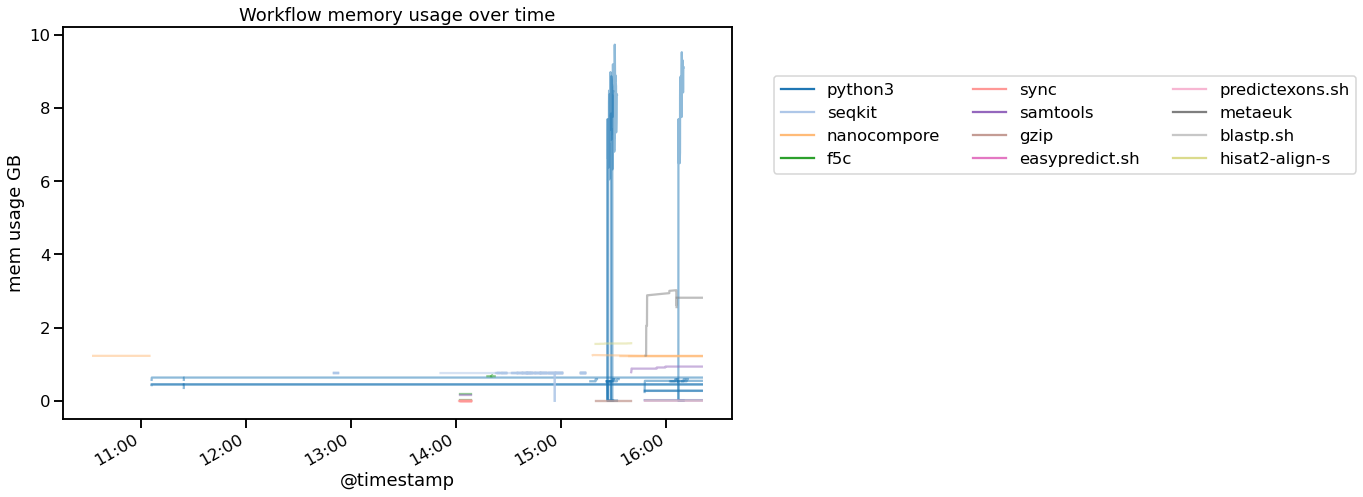

In [9]:
# remove duplicate legends
# https://stackoverflow.com/a/56253636
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    leg = ax.legend(*zip(*unique), loc='center left', bbox_to_anchor=(1.05, 0.75), ncol=3, fancybox=True)
    # Set legend to alpha=1.0
    # https://stackoverflow.com/a/42403471
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

fig, ax = plt.subplots(figsize=(12,8))
# Get a color map
cmap = cm.get_cmap('tab20')

colors = {}

bad_progs = ["sh", "perl"]

# Give each process a unique color
for n, color in zip(name, cmap.colors):
    if n in bad_progs:
        continue
    if n in colors.keys():
        continue
    else:
        print(n)
        colors[n] = color

# Plot the memory usage over time including all processes
for n, c in zip(name, counts):
    if n in bad_progs:
        continue
    data = total_data[total_data['name'] == n]
    pids = data.pid.unique()

    for pid in pids:
        process_data = data[data.pid == pid]
        if len(process_data) < 100:
            continue
        process_data = data[data.pid == pid]
        mem = process_data.mem_vms_GB.rolling("1s").mean()
        try:
            mem.plot(c=colors[n], alpha=0.5, label=n)
        except KeyError:
            mem.plot(c='black', alpha=0.5, label="")

legend_without_duplicate_labels(ax)
date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)
# plt.ylim(0, 6)
plt.title(f'Workflow memory usage over time')
plt.ylabel("mem usage GB")
plt.show()

'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bamCoverage'
'bgzip'
'bgzip'
'hisat2-build-s'
'

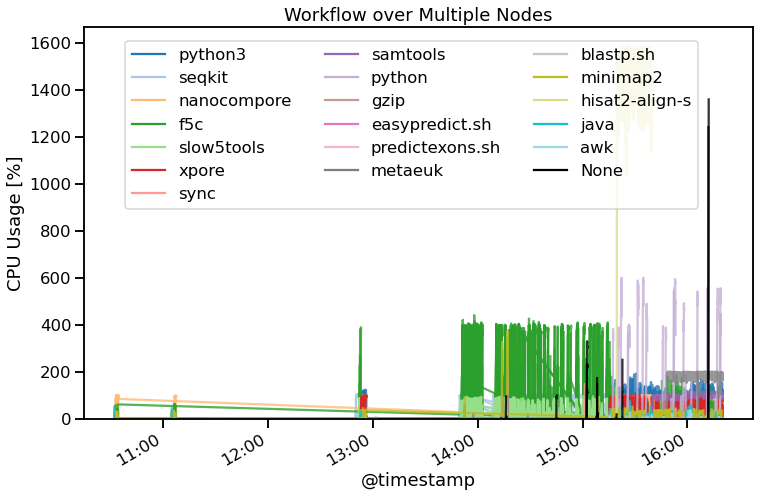

In [10]:
total_data.sort_index(inplace=True)

# remove duplicate legends
# https://stackoverflow.com/a/56253636
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    leg = ax.legend(*zip(*unique), loc='center left', bbox_to_anchor=(0.05, 0.75), ncol=3, fancybox=True)
    # Set legend to alpha=1.0
    # https://stackoverflow.com/a/42403471
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

fig, ax = plt.subplots(figsize=(12,8))

# Give each process a unique color
for n, color in zip(name, cmap.colors):
    if n in bad_progs:
        continue
    if n in colors.keys():
        continue
    else:
        print(n)
        colors[n] = color
        
# bad_progs = ["pigz","mv", "sh", "perl", "cp", "data_plugin", "curl_plugin", "hisat2-align-s", "bamCoverage", "featureCounts"]
# Plot the memory usage over time including all processes
for n, c in zip(name, counts):
    if n in bad_progs:
        continue
    data = total_data[total_data['name'] == n]
    # data = data[data.index > "2022-08-31 09:00:00.000000"]
    pids = data.pid.unique()

    for pid in pids:
        process_data = data[data.pid == pid]
        nid = process_data.node.iloc[0]
        jid = process_data.jobid.iloc[0]
        if len(process_data) > 10000:
            continue
        # This only works because we get the derivative over 10 seconds
        # You need to change a bit for different time intervals
        total_cpu_time = (process_data.cpu_system + process_data.cpu_user + process_data.cpu_iowait)
        cpu = (100/10)*(total_cpu_time).rolling('10s').apply(lambda x: x[-1] - x[0])
        cpu.resample('120s')
        try:
            cpu.plot(c=colors[n], alpha=0.8, label=n)
        except KeyError as e:
            print(e)
            cpu.plot(c='black', alpha=0.8)

# plt.ylim(0,120)
legend_without_duplicate_labels(ax)

date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)
plt.ylim(0, None)
# plt.title(f'Node {nid} CPU usage jobid {jid}')
plt.title(f'Workflow over Multiple Nodes')
plt.ylabel("CPU Usage [%]")
plt.show()

In [11]:
colors

{'python3': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'seqkit': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'nanocompore': (1.0, 0.7333333333333333, 0.47058823529411764),
 'f5c': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'slow5tools': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'xpore': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'sync': (1.0, 0.596078431372549, 0.5882352941176471),
 'samtools': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'python': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 'gzip': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 'easypredict.sh': (0.8901960784313725,
  0.4666666666666667,
  0.7607843137254902),
 'predictexons.sh': (0.9686274509803922,
  0.7137254901960784,
  0.8235294117647058),
 'metaeuk': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 'blastp.sh': (0.7803921568627451, 0.7803921568627

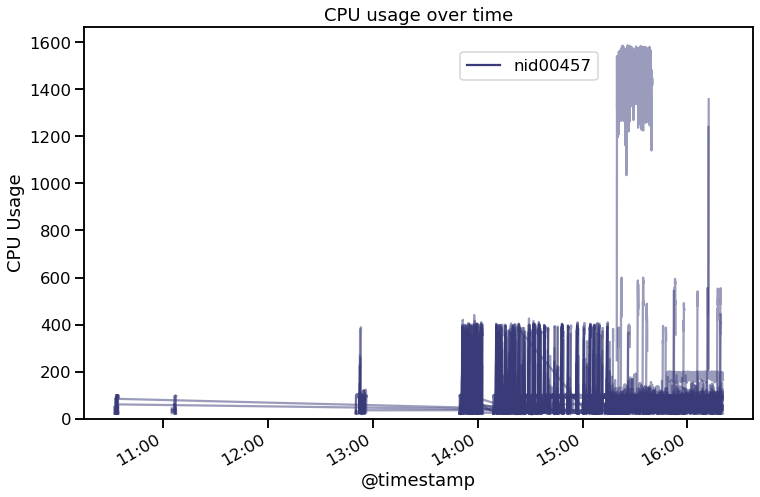

In [12]:
total_data.sort_index(inplace=True)

# remove duplicate legends
# https://stackoverflow.com/a/56253636
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    leg = ax.legend(*zip(*unique), loc='center left', bbox_to_anchor=(0.55, 0.9), ncol=3, fancybox=True)
    # Set legend to alpha=1.0
    # https://stackoverflow.com/a/42403471
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

fig, ax = plt.subplots(figsize=(12,8))

nodes = total_data.node.unique()
cmap = cm.get_cmap('tab20b')
x = list(cmap.colors)

colors = {}
# Give each process a unique color
for n, color in zip(nodes, x):
    if n in colors.keys():
        continue
    else:
        colors[n] = color
        
good_prog = ["spades-core"]
# Plot the memory usage over time including all processes
for n, c in zip(name, counts):
    data = total_data[total_data['name'] == n]
    pids = data.pid.unique()

    for pid in pids:
        process_data = data[data.pid == pid]
        nid = process_data.iloc[0].node
        if len(process_data) > 10000:
            continue
        # This only works because we get the derivative over 10 seconds
        # You need to change a bit for different time intervals
        total_cpu_time = (process_data.cpu_system + process_data.cpu_user + process_data.cpu_iowait)
        cpu = (100/10)*(total_cpu_time).rolling('10s').apply(lambda x: x[-1] - x[0])
        cpu.resample('120s')
        
        cpu = cpu[cpu > 20]
        try:
            if len(cpu) > 0:
                cpu.plot(c=colors[nid], alpha=0.5, label=nid)
        except KeyError as e:
            print(e)
            cpu.plot(c='black', alpha=0.8)

# plt.ylim(0,120)
legend_without_duplicate_labels(ax)

date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)
# plt.ylim(0, 145)
plt.ylim(0, None)
plt.title(f'CPU usage over time')
plt.ylabel("CPU Usage")
plt.show()

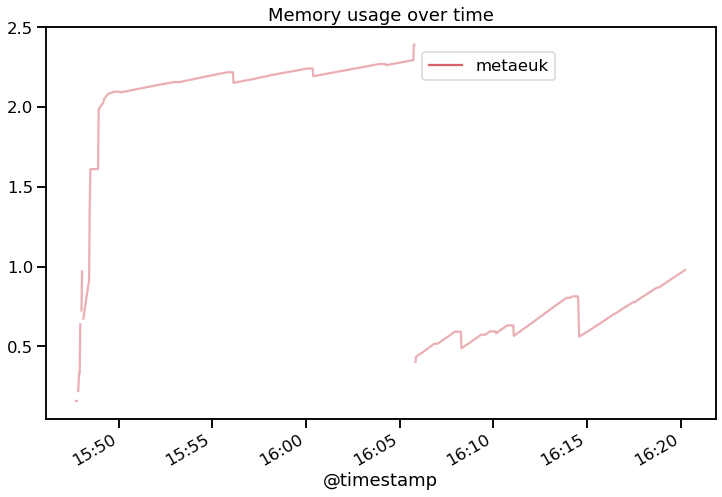

In [14]:
total_data.sort_index(inplace=True)

# remove duplicate legends
# https://stackoverflow.com/a/56253636
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    leg = ax.legend(*zip(*unique), loc='center left', bbox_to_anchor=(0.55, 0.9), ncol=3, fancybox=True)
    # Set legend to alpha=1.0
    # https://stackoverflow.com/a/42403471
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

fig, ax = plt.subplots(figsize=(12,8))

nodes = total_data.node.unique()
cmap = cm.get_cmap('tab20b')
x = list(cmap.colors)

good_prog = ["metaeuk"]

colors = {}
# Give each process a unique color
for n, color in zip(name, x):
    if n not in good_prog:
        continue
    if n in colors.keys():
        continue
    else:
        colors[n] = color
        
memory = []

# Plot the memory usage over time including all processes
for n, c in zip(name, counts):
    if n not in good_prog:
        continue
    data = total_data[total_data['name'] == n]
    # data = data[(data.index > "2022-07-13 13:00:00.000000") & (data.index < "2022-07-13 14:00:00.000000")]
    pids = data.pid.unique()

    for pid in pids:
        process_data = data[data.pid == pid]
        nid = process_data.iloc[0].node
#         if len(process_data) > 100000:
#             continue
        mem = process_data.mem_rss_GB.rolling("20s").max()
        mem_vms = process_data.mem_vms_GB.rolling("20s").max()
        try:

            mem.plot(c=colors[n], alpha=0.5, label=n)
            # mem_vms.plot(c=colors[n], alpha=0.5, label=n)
        except KeyError as e:
            print(e)
            cpu.plot(c='black', alpha=0.8)

# plt.ylim(0,120)
legend_without_duplicate_labels(ax)

date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)
# plt.ylim(0, 20)
plt.title(f'Memory usage over time')
# plt.ylabel("CPU Usage")
plt.show()